# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [1]:
dataDir = "E:/AV/DataSetExploration/drone-dataset-tools/data/location-2/home"
# dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2/lab"
# dataDir = "/home/office/AV/DataSetExploration/data/ind/location-2/csv"

In [2]:
exec(open('init_notebook.py').read())

current working dirE:\AV\DataSetExploration\TTI-dataset-tools\src


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from tti_dataset_tools.ColMapper import ColMapper

In [5]:
from ind_tools.IndTransformer import IndTransformer

In [6]:
sceneId = 31
# date = "2022-12-22"
date = "2022-12-09"
fps=5
minYDisplacement = 5
maxXDisplacement = 9
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))


In [7]:
visualizer = TrajectoryVisualizer()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity', 
        speedCol='speed',
        fps=fps,
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)

indTransformer = IndTransformer(colMapper)

In [8]:
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
pedDf.describe()

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY
count,528.000000,528.000000,528.000000,528.0,528.0,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000
mean,22.717803,8753.085227,22885.259470,31.0,6.0,0.474214,-0.071449,-0.024853,0.099388,-0.002892,0.028004,1.246630,2.253737,2.957936
std,2.466840,6829.796762,2497.237173,0.0,0.0,2.266470,1.786867,0.824696,1.011684,0.235636,0.258146,0.396369,1.795115,1.873743
min,19.000000,10.000000,19019.000000,31.0,6.0,-4.008711,-3.203301,-1.607051,-1.709948,-0.784918,-1.216581,0.061354,0.000000,0.000000
25%,21.000000,3881.750000,21328.000000,31.0,6.0,-1.340639,-1.635851,-0.700060,-0.953119,-0.153128,-0.127347,1.036170,0.642348,1.298364
50%,23.000000,7410.500000,23391.000000,31.0,6.0,0.626289,0.029482,-0.302015,0.573148,-0.018229,-0.004213,1.253673,1.966942,3.003703
75%,24.000000,11425.250000,24171.000000,31.0,6.0,2.222980,1.359514,0.838349,0.886357,0.144828,0.158022,1.477055,3.458584,4.624927
max,29.000000,22431.000000,29431.000000,31.0,6.0,4.957891,3.091342,1.752805,1.630419,0.821041,1.193489,2.336267,7.599619,6.032311


In [10]:
# plt.boxplot(pedDf['displacementY'])
# plt.show()
# plt.boxplot(pedDf['speed'])

## Preprocessing data

### 1. filter out data with low Y displacement

In [14]:
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)
# visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')

using min Y displacement (5)


### 2. Transform trajectories to local source coordinate system

In [15]:
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)
# cleanPedDf.head()

### 3. Rotate north-south trajectories to south-north trajectories

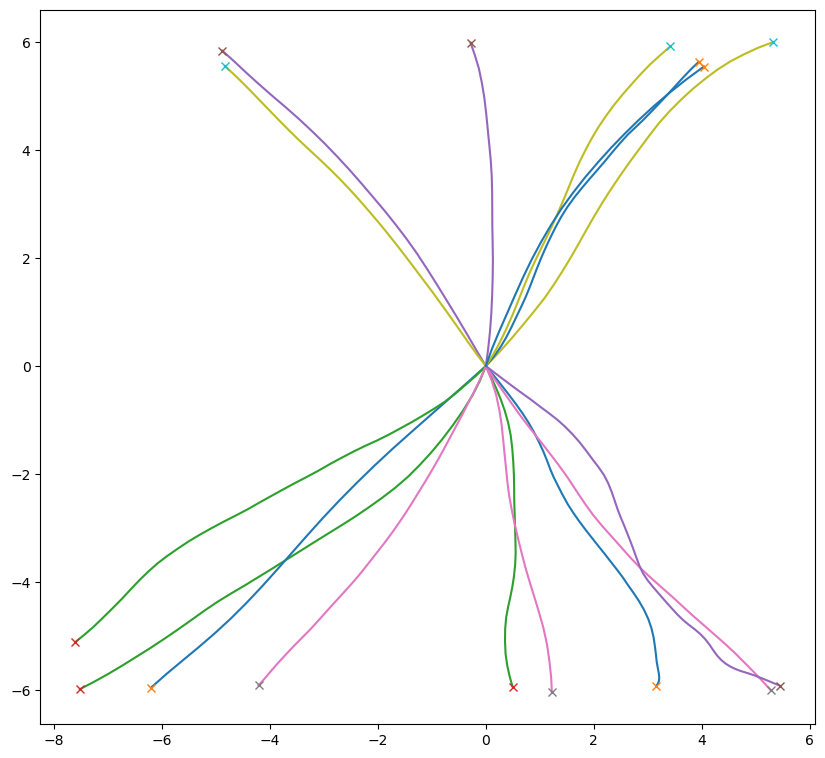

In [18]:
southIds, northDf = indTransformer.convertLocalToNorth(cleanPedDf, tracksMeta)
visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

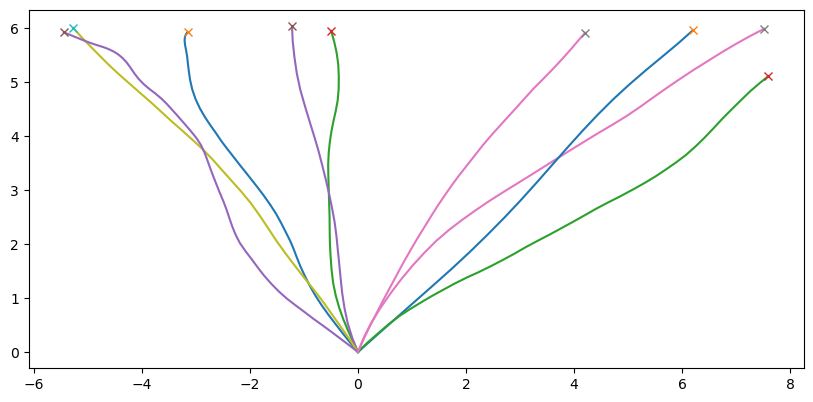

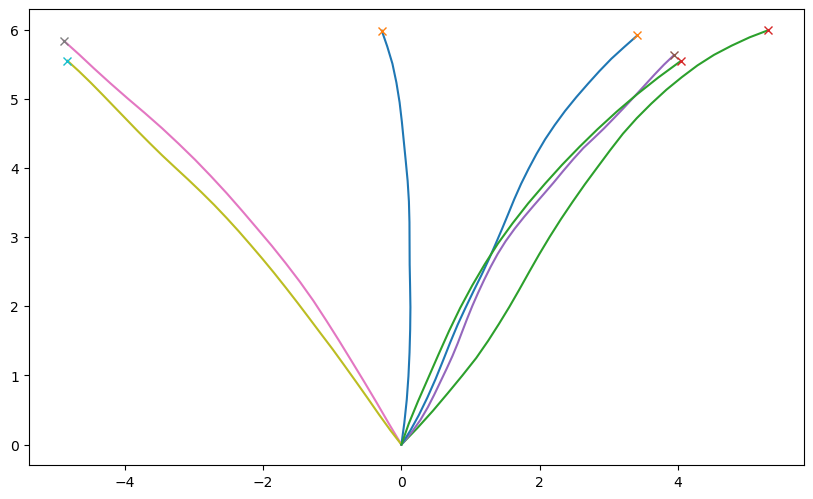

In [19]:
southPeds = northDf[northDf["uniqueTrackId"].isin(southIds)]
visualizer.show(southPeds, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
northPeds = northDf[~northDf["uniqueTrackId"].isin(southIds)]
visualizer.show(northPeds, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

### 4. Shape Analysis from Local Source

### Shape dependencies:
1. spline based clustering
2. language based clustering


#### 5.1 Polygon

In [21]:
from tti_dataset_tools import CrosswalkModel
crosswalkModel = CrosswalkModel(colMapper)

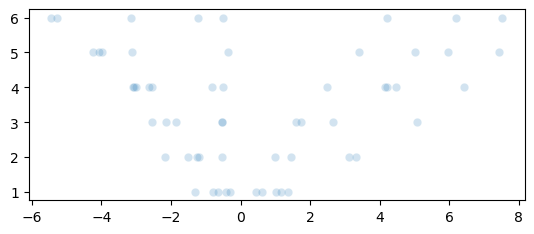

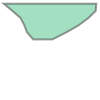

In [28]:
roadWidth = 6.0
interval = 1.0
yTolerance = 0.1

yBreakpoints = list(np.arange(interval, roadWidth, interval))
if (yBreakpoints[-1] - roadWidth) < 0.2:
    yBreakpoints.append(roadWidth)
    
breakpointXVals = crosswalkModel.getAllLocalXAtLocalYBreakpoints(
        tracksDf = southPeds,
        yBreakpoints = yBreakpoints,
        yTolerance = yTolerance
    )
visualizer.showBreakpointVals(breakpointXVals)
polygon = crosswalkModel.generatePolygonFromBreakpointVals(breakpointXVals)
polygon